# HDS 5230 High Performance Computing

## Final Exam - Progamming Part


*Miao Cai* <miao.cai@slu.edu>

# Introduction

The big goal of this project is to use the provided dataset on health insurance charges to create a model that predicts charges as accurately as possible, based on the patient traits of age, sex, bmi, children, smoker, and region. As I generate this model, I performed and documented initial data quality checks, exploratory data analysis, and all of the models I tried to fit.

# Methods summary

All the data cleaning, visualization, and modeling were conducted in Python, and this reported was wrote in jupyternotebook. The Python session and package version information is shown below.

In [38]:
import os
import sys
import pathlib
from tableone import TableOne
import pandas as pd
import numpy as np
import seaborn as sns
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

print(sys.version)
print("Pandas version: {0}".format(pd.__version__))
print("Numpy version:{0}".format(np.__version__))
print("Seaborn version:{0}".format(sns.__version__))
print("h2o version:{0}".format(h2o.__version__))
print("My working directory:\n" + os.getcwd())

3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version: 0.23.4
Numpy version:1.15.4
Seaborn version:0.9.0
h2o version:3.22.1.3
My working directory:
/Users/miaocai/Dropbox/@2018 SPRING HDS5230 High performance computing/HDS5230Homework/Final exam


### Loss function

I pick the loss function as the mean absolute error (MAE). I chose this loss function since the outcome variable charges are highly right-skewed. Using the most commonly used mean square error (MSE) will not be as robust as MAE since the error will be squared, which is strongly influenced by outliers.

### Initiate h2o and read data

In [39]:
h2o.init(ip='localhost', port=54321, nthreads=-1, max_mem_size='2G')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,18 hours 33 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,3 months and 17 days !!!
H2O cluster name:,H2O_from_python_miaocai_k7904q
H2O cluster total nodes:,1
H2O cluster free memory:,1.963 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [40]:
d0 = h2o.import_file("insurance.csv")
d0

Parse progress: |█████████████████████████████████████████████████████████| 100%


age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.9
18,male,33.77,1,no,southeast,1725.55
28,male,33,3,no,southeast,4449.46
33,male,22.705,0,no,northwest,21984.5
32,male,28.88,0,no,northwest,3866.86
31,female,25.74,0,no,southeast,3756.62
46,female,33.44,1,no,southeast,8240.59
37,female,27.74,3,no,northwest,7281.51
37,male,29.83,2,no,northeast,6406.41
60,female,25.84,0,no,northwest,28923.1


In [41]:
print("The shape of the DataFrame is:")
print(d0.shape)
list(zip(d0.nacnt(), d0.names))

The shape of the DataFrame is:
(1338, 7)


[(0.0, 'age'),
 (0.0, 'sex'),
 (0.0, 'bmi'),
 (0.0, 'children'),
 (0.0, 'smoker'),
 (0.0, 'region'),
 (0.0, 'charges')]

After reading the .csv file by using h2o, I found that there are no missing values in the data, which is great! 

### Split into train/validation/testing splits

We then need to convert some categorical variables into factors, and split the data into train, test, and validation sets.

In [42]:
d0[['sex', 'smoker', 'region']] = d0[['sex', 'smoker', 'region']].asfactor()
dtrain, dtest, dvalid = \
    d0.split_frame([0.7, 0.15], seed = 666)

# Results

## Summary statistics of model input variables

In [43]:
d = pd.read_csv("insurance.csv")
col_types = d.dtypes.to_dict()
col_types['age'] = 'float64'
d = pd.read_csv("insurance.csv", dtype=col_types)

overall_table = TableOne(
    d, columns = ['age', 'bmi', 'children', 'smoker', 'region'], 
    categorical = ['children', 'smoker', 'region'], 
    groupby = 'sex', label_suffix=True, pval = True)
overall_table

Grouped by sex                                                    
                                  isnull       female         male   pval              ptest
variable        level                                                                       
n                                                 662          676                          
age, mean (SD)                         0  39.5 (14.1)  38.9 (14.1)  0.446  Two Sample T-test
bmi, mean (SD)                         0   30.4 (6.0)   30.9 (6.1)  0.090  Two Sample T-test
children, n (%) 0                      0   289 (43.7)   285 (42.2)  0.981        Chi-squared
                1                          158 (23.9)   166 (24.6)                          
                2                          119 (18.0)   121 (17.9)                          
                3                           77 (11.6)    80 (11.8)                          
                4                            11 (1.7)     14 (2.1)                          
                5                             8 (1.2)     10 (1.5)                          
smoker, n (%)   no                     0   547 (82.6)   517 (76.5)  0.007        Chi-squared
                yes                        115 (17.4)   159 (23.5)                          
region, n (%)   northeast              0   161 (24.3)   163 (24.1)  0.933        Chi-squared
                northwest                  164 (24.8)   161 (23.8)                          
                southeast                  175 (26.4)   189 (28.0)                          
                southwest                  162 (24.5)   163 (24.1)                          
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: age.
[2] Warning, test for normality reports non-normal distributions for: age.

## Descriptive analysis of the outcome variable charges

/Users/miaocai/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


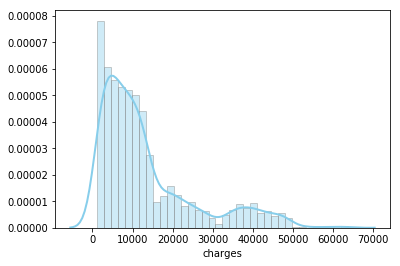

In [44]:
sns.distplot(d['charges'], hist=True, kde=True, 
             bins=int(180/5), color = 'skyblue', 
             hist_kws={'edgecolor':'grey'},
             kde_kws={'linewidth': 2})

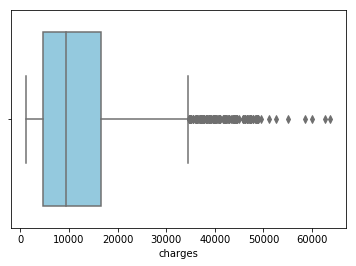

In [45]:
sns.boxplot(d['charges'], color = 'skyblue')

In [46]:
d['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

## Cross-validation

Here I use the `H2OGeneralizedLinearEstimator` module in `h2o` package to perform cross-validation. I set the number of cross-validation as 5 by `nfolds=5`, in which 6 models will be built. The first 5 models (cross-validation models) are built on 80% of the training data, and a different 20% is held out for each of the 5 models. Then the main model is built on 100% of the training data.

In [47]:
target_var = 'charges'
input_var = ['age', 'sex', 'bmi', 
             'children', 'smoker', 'region']
glm_mod0 = \
    H2OGeneralizedLinearEstimator(model_id = 'd_glm_0',
                                  family = 'gaussian',
                                  nfolds = 5,
                                  seed = 123)
glm_mod0.train(x = input_var, 
               y = target_var, 
               training_frame = d0)
glm_mod0.show()

glm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  d_glm_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 125728309.44330035
RMSE: 11212.863570172445
MAE: 8471.397911142334
RMSLE: 0.9331157151413909
R^2: 0.14203674139265943
Mean Residual Deviance: 125728309.44330035
Null degrees of freedom: 1337
Residual degrees of freedom: 1326
Null deviance: 196074221532.74988
Residual deviance: 168224478035.13586
AIC: 28776.289622947068

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 129830749.84711617
RMSE: 11394.32972346843
MAE: 8600.97548619905
RMSLE: 0.9464119017196216
R^2: 0.11404190751089327
Mean Residual Deviance: 129830749.84711617
Null degrees of freedom: 1337
Residual degrees of freedom: 1326
Null deviance: 196632689167.88873
Residual deviance: 173713543295.44144
AIC: 28819.25062652632
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,8592.547,295.31107,8582.3125,7818.5264,8785.108,8714.119,9062.668
mean_residual_deviance,129275808.0000000,12568459.0000000,122953088.0000000,102175632.0000000,153850944.0000000,124694504.0000000,142704864.0000000
mse,129275808.0000000,12568459.0000000,122953088.0000000,102175632.0000000,153850944.0000000,124694504.0000000,142704864.0000000
null_deviance,39326540000.0000000,4538068000.0000000,37283930000.0000000,29694271500.0000000,49030697000.0000000,37774651000.0000000,42849141000.0000000
r2,0.1105586,0.0058998,0.1174623,0.1147653,0.1004910,0.1195456,0.1005287
residual_deviance,34742710000.0000000,4171281920.0000000,32705521700.0000000,26156961800.0000000,43847520000.0000000,33044043800.0000000,37959496000.0000000
rmse,11342.573,557.5985,11088.422,10108.196,12403.667,11166.67,11945.914
rmsle,0.9458453,0.0343231,0.9813831,0.9140743,0.8841538,1.0196682,0.9299473


Scoring History: 


,timestamp,duration,iterations,negative_log_likelihood,objective
,2019-05-12 22:43:32,0.000 sec,0,196074221568.3671875,146542766.4935480


## Machine learning

### Regularized regression


In [48]:
from h2o.grid.grid_search import H2OGridSearch

alpha_values = {'alpha': [0, 0.25, 0.5, 0.75, 1]}
glm_mod2 = H2OGridSearch(
    H2OGeneralizedLinearEstimator(family = 'gaussian',
                                  lambda_search = True,
                                  seed = 123), \
hyper_params = alpha_values)

glm_mod2.train(x = input_var, 
               y = target_var, 
               training_frame = dtrain,
              validation_frame = dvalid)

glm_mod2.show()

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                     model_ids  \
0     [1.0]  Grid_GLM_py_10_sid_929a_model_python_1557652172496_3_model_5   
1    [0.75]  Grid_GLM_py_10_sid_929a_model_python_1557652172496_3_model_4   
2     [0.5]  Grid_GLM_py_10_sid_929a_model_python_1557652172496_3_model_3   
3    [0.25]  Grid_GLM_py_10_sid_929a_model_python_1557652172496_3_model_2   
4     [0.0]  Grid_GLM_py_10_sid_929a_model_python_1557652172496_3_model_1   

       residual_deviance  
0    6.232294045221491E9  
1  2.7448416102541004E10  
2  2.7451841045226257E10  
3  2.7452983289290577E10  
4  2.7453233838145943E10  


In [49]:
glm_best = glm_mod2.get_grid()[0]
glm_best._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-7206.776563,13492.999531
1,region.northeast,83.984427,83.984427
2,region.northwest,111.459665,111.459665
3,region.southeast,-192.376821,-192.376821
4,region.southwest,-70.256674,-70.256674
5,smoker.no,-5020.292788,-5020.292788
6,smoker.yes,18846.423625,18846.423625
7,sex.female,147.142857,147.142857
8,sex.male,-142.895434,-142.895434
9,age,255.041295,3604.495432


In [50]:
glm_best._model_json['output']['training_metrics']


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 36244089.05252515
RMSE: 6020.306391914381
MAE: 4175.590832941357
RMSLE: NaN
R^2: 0.7557379707834732
Mean Residual Deviance: 36244089.05252515
Null degrees of freedom: 955
Residual degrees of freedom: 944
Null deviance: 141853194478.7002
Residual deviance: 34649349134.21404
AIC: 19378.942718761107


In [51]:
glm_best._model_json['output']['validation_metrics']


ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 30107700.701553095
RMSE: 5487.04845081152
MAE: 3827.8094066015087
RMSLE: 0.5274009774363978
R^2: 0.7699240420817869
Mean Residual Deviance: 30107700.701553095
Null degrees of freedom: 206
Residual degrees of freedom: 195
Null deviance: 27453554523.254715
Residual deviance: 6232294045.221491
AIC: 4178.040900338396


### Auto-ML

In [52]:
from h2o.automl.autoh2o import H2OAutoML

autom1_1 = H2OAutoML(max_runtime_secs = 60)
autom1_1.train(x = input_var, 
               y = target_var, 
               training_frame = dtrain,
               validation_frame = dvalid)
autom1_1.leaderboard

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_grid_1_AutoML_20190512_224333_model_2,1.97843e+07,4447.96,1.97843e+07,2432.79,0.413184
XGBoost_3_AutoML_20190512_224333,2.04295e+07,4519.9,2.04295e+07,2408.7,0.423944
XGBoost_grid_1_AutoML_20190512_224333_model_4,2.04979e+07,4527.46,2.04979e+07,2505.46,0.436286
XGBoost_1_AutoML_20190512_224333,2.05022e+07,4527.93,2.05022e+07,2468.91,0.423831
XGBoost_2_AutoML_20190512_224333,2.10117e+07,4583.86,2.10117e+07,2476,0.441066
XGBoost_grid_1_AutoML_20190512_224333_model_5,2.16251e+07,4650.28,2.16251e+07,2535.24,nan
GBM_2_AutoML_20190512_224333,2.1733e+07,4661.87,2.1733e+07,2775.77,0.464753
GBM_grid_1_AutoML_20190512_224333_model_11,2.22032e+07,4712.02,2.22032e+07,3058.62,0.479175
GBM_4_AutoML_20190512_224333,2.23753e+07,4730.26,2.23753e+07,2852.66,0.472327
XGBoost_grid_1_AutoML_20190512_224333_model_1,2.26268e+07,4756.76,2.26268e+07,2649.82,0.463984


In [53]:
autom1_1.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190512_224333_model_2


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 14528508.374148928
RMSE: 3811.6280477177897
MAE: 2022.629675446195
RMSLE: 0.33941648050977435
Mean Residual Deviance: 14528508.374148928

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 18054575.204083566
RMSE: 4249.067568783011
MAE: 2344.0509905976373
RMSLE: 0.38510422313361437
Mean Residual Deviance: 18054575.204083566

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 19784318.805394568
RMSE: 4447.956700035936
MAE: 2432.7904463891705
RMSLE: 0.41318440454888644
Mean Residual Deviance: 19784318.805394568
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2432.7295,74.70777,2490.9307,2286.081,2333.1685,2485.9092,2567.5583
mean_residual_deviance,19781598.0000000,1548789.5,22382870.0000000,19526344.0000000,17453224.0000000,17350560.0000000,22194988.0000000
mse,19781598.0000000,1548789.5,22382870.0000000,19526344.0000000,17453224.0000000,17350560.0000000,22194988.0000000
r2,0.8648089,0.0109681,0.8722137,0.8360478,0.8811800,0.8718028,0.8627998
residual_deviance,19781598.0000000,1548789.5,22382870.0000000,19526344.0000000,17453224.0000000,17350560.0000000,22194988.0000000
rmse,4440.8354,174.0357,4731.0537,4418.8623,4177.7056,4165.4004,4711.156
rmsle,0.4125335,0.0165132,0.4039368,0.4385948,0.4182793,0.3720201,0.4298366


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-05-12 22:43:58,8.165 sec,0.0,18177.7211428,13492.4995221,330429545.9456137,16697.6769005,12163.5761206,278812413.8726478
,2019-05-12 22:43:58,8.176 sec,5.0,14425.1967418,10417.2924807,208086301.0383629,13312.4690498,9370.0704254,177221832.2006640
,2019-05-12 22:43:58,8.184 sec,10.0,11562.4688692,8073.2961273,133690686.3519351,10740.2396373,7258.8249877,115352747.4656878
,2019-05-12 22:43:58,8.195 sec,15.0,9388.8609946,6304.4790556,88150710.7758984,8801.4893580,5669.2650312,77466214.9193138
,2019-05-12 22:43:58,8.203 sec,20.0,7765.6711330,5018.1303193,60305648.1453410,7400.4861750,4558.7514418,54767195.6265089
---,---,---,---,---,---,---,---,---,---
,2019-05-12 22:43:58,8.333 sec,80.0,3900.1432465,2049.8709799,15211117.3434129,4249.4535400,2309.1517287,18057855.3889892
,2019-05-12 22:43:58,8.347 sec,85.0,3872.9667308,2046.1287795,14999871.2976686,4241.2141376,2323.1174641,17987897.3609924
,2019-05-12 22:43:58,8.361 sec,90.0,3851.6525352,2031.3362383,14835227.2519658,4237.8315973,2314.1712269,17959216.6473966
,2019-05-12 22:43:58,8.376 sec,95.0,3828.6288679,2024.7918645,14658399.0081565,4247.3179679,2333.3710342,18039709.9203603



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
smoker.no,454322782208.0000000,1.0,0.5573600
bmi,148791967744.0000000,0.3275028,0.1825370
age,102772113408.0000000,0.2262095,0.1260801
smoker.yes,90579763200.0000000,0.1993731,0.1111226
children,8185817600.0000000,0.0180176,0.0100423
region.southeast,3672467456.0000000,0.0080834,0.0045054
region.northeast,2915814656.0000000,0.0064179,0.0035771
sex.female,1918903296.0000000,0.0042237,0.0023541
region.southwest,1108210176.0000000,0.0024393,0.0013595
sex.male,473684672.0000000,0.0010426,0.0005811


In [54]:
autom1_1.leader.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2432.7295,74.70777,2490.9307,2286.081,2333.1685,2485.9092,2567.5583
mean_residual_deviance,19781598.0000000,1548789.5,22382870.0000000,19526344.0000000,17453224.0000000,17350560.0000000,22194988.0000000
mse,19781598.0000000,1548789.5,22382870.0000000,19526344.0000000,17453224.0000000,17350560.0000000,22194988.0000000
r2,0.8648089,0.0109681,0.8722137,0.8360478,0.8811800,0.8718028,0.8627998
residual_deviance,19781598.0000000,1548789.5,22382870.0000000,19526344.0000000,17453224.0000000,17350560.0000000,22194988.0000000
rmse,4440.8354,174.0357,4731.0537,4418.8623,4177.7056,4165.4004,4711.156
rmsle,0.4125335,0.0165132,0.4039368,0.4385948,0.4182793,0.3720201,0.4298366


## Neural networks using kera and tensorflow

In [55]:
from keras import models
from keras import layers
from keras import optimizers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

d = pd.read_csv("insurance.csv")
col_types = d.dtypes.to_dict()
col_types['age'] = 'float64'
d = pd.read_csv("insurance.csv", dtype=col_types)

d_dummy = pd.get_dummies(d, drop_first = True)
y = d_dummy['charges'].values
X = d_dummy.drop('charges', axis = 1).values

X_train0, X_test0 = train_test_split(
    X, train_size = 0.8, random_state = 123)
y_train0, y_test0 = train_test_split(
    y, train_size = 0.8, random_state = 123)
X_train1, X_valid1 = train_test_split(
    X, train_size = 0.75, random_state = 123)
y_train1, y_valid1 = train_test_split(
    y, train_size = 0.75, random_state = 123)

# logistic regression
def nn_model1():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu',
                          input_dim = X_train1.shape[1]))
    model.add(layers.Dense(1,
                          activation = 'linear'))
    model.compile(optimizer = 'rmsprop',
                 loss = 'mse',
                 metrics = ['mae'])
    return model

reg0 = nn_model1()
reg0.fit(X_train1, y_train1, epochs = 200, 
         validation_data = [X_valid1, y_valid1],
        verbose = 0)

/Users/miaocai/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [56]:
reg0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [57]:
reg0.history.history['loss'][199]

125524612.95314057

In [58]:
reg0.history.history['val_loss'][199]

132704983.57014926

In [59]:
reg0.history.history['val_mean_absolute_error'][199]

9081.118927821828

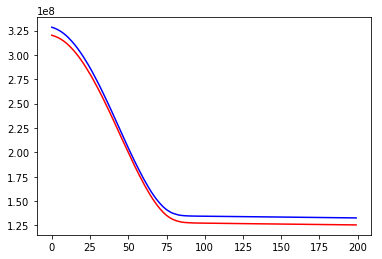

In [60]:
plt.plot(reg0.history.history['loss'], color = 'red')
plt.plot(reg0.history.history['val_loss'], color = 'blue')

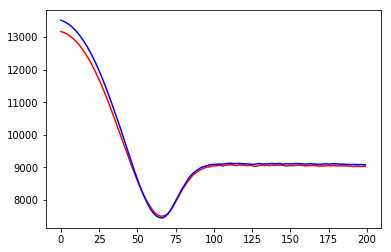

In [61]:
plt.plot(reg0.history.history['mean_absolute_error'], color = 'red')
plt.plot(reg0.history.history['val_mean_absolute_error'], color = 'blue')

In [62]:
def nn_model2():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu',
                          input_dim = X_train1.shape[1]))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation = 'linear'))
    model.compile(optimizer = 'rmsprop',
                 loss = 'mse',
                 metrics = ['mae'])
    return model

reg2 = nn_model2()
reg2.fit(X_train1, y_train1, epochs = 200, 
         validation_data = [X_valid1, y_valid1],
        verbose = 0)

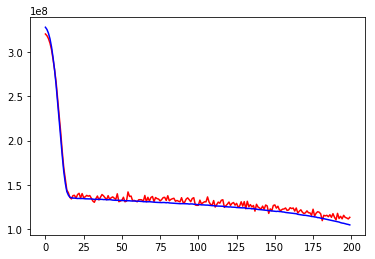

In [63]:
plt.plot(reg2.history.history['loss'], color = 'red')
plt.plot(reg2.history.history['val_loss'], color = 'blue')

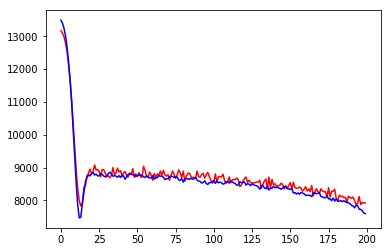

In [64]:
plt.plot(reg2.history.history['mean_absolute_error'], color = 'red')
plt.plot(reg2.history.history['val_mean_absolute_error'], color = 'blue')

### A more complex model with dropout, L1 regularization, smaller weight

In [65]:
from keras.regularizers import l1

def nn_model3(l1_penalty):
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu',
                           kernel_regularizer = 
                               l1(l1_penalty),
                          input_dim = X_train1.shape[1]))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation = 'relu', 
                          kernel_regularizer = l1(l1_penalty)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation = 'linear'))
    model.compile(optimizer = 'rmsprop',
                 loss = 'mse',
                 metrics = ['mae'])
    return model

In [66]:
reg3 = nn_model3(0.1)
reg3.fit(X_train1, y_train1, epochs = 200, 
         validation_data = [X_valid1, y_valid1],
        verbose = 0)
reg3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


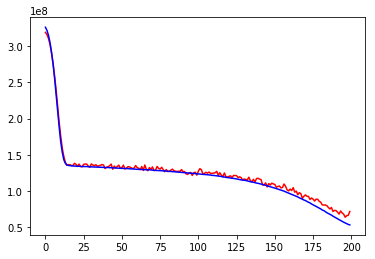

In [67]:
plt.plot(reg3.history.history['loss'], color = 'red')
plt.plot(reg3.history.history['val_loss'], color = 'blue')

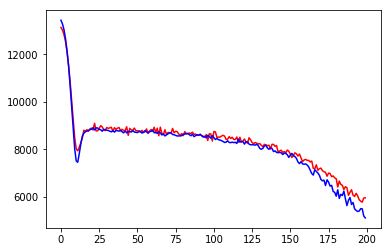

In [68]:
plt.plot(reg3.history.history['mean_absolute_error'], color = 'red')
plt.plot(reg3.history.history['val_mean_absolute_error'], color = 'blue')

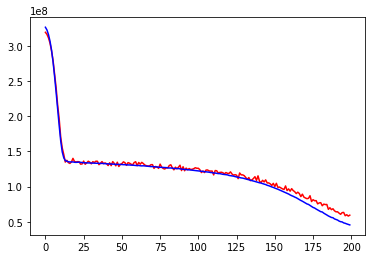

In [69]:
reg3 = nn_model3(0.2)
reg3.fit(X_train1, y_train1, epochs = 200, 
         validation_data = [X_valid1, y_valid1],
        verbose = 0)
plt.plot(reg3.history.history['loss'], color = 'red')
plt.plot(reg3.history.history['val_loss'], color = 'blue')

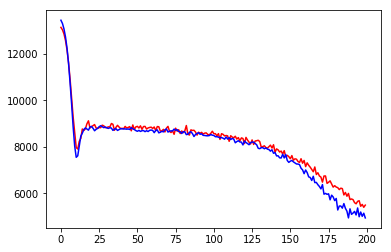

In [70]:
plt.plot(reg3.history.history['mean_absolute_error'], color = 'red')
plt.plot(reg3.history.history['val_mean_absolute_error'], color = 'blue')

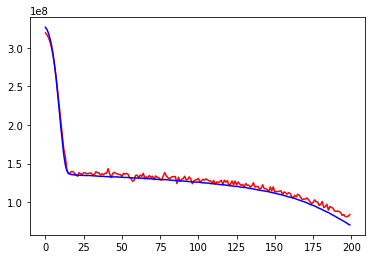

In [71]:
reg3 = nn_model3(0.3)
reg3.fit(X_train1, y_train1, epochs = 200, 
         validation_data = [X_valid1, y_valid1],
        verbose = 0)
plt.plot(reg3.history.history['loss'], color = 'red')
plt.plot(reg3.history.history['val_loss'], color = 'blue')

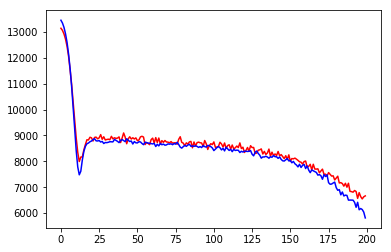

In [72]:
plt.plot(reg3.history.history['mean_absolute_error'], color = 'red')
plt.plot(reg3.history.history['val_mean_absolute_error'], color = 'blue')

# Conclusion

Based on the machine learning and deep learning models used above, I found that using XGBoost provided in `auto-ML` tool provided by `h2o` tends to have the best model prediction performance. With regard to deep learning models, a two-layer neural network with L1 regularization seems to have the best prediction performance.